In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import math
import matplotlib as mpl

# Assignment 3 - Clustering

For this assignment you'll need to use some clustering knowledge to build a function that can generate handwritten numbers from a provided number. 

The modelling parts of this assignment are not very complex, the application of the clustering algorithms is very similar to the examples from class. This will require a little more manipulation of data, and building a little bit of structure around the models, that's where some of the challenge lies. 

## Requirements
<ul>
<li>Use clustering to take the X data (the features/pixels) of the MNIST dataset, and group it into clusters. 
    <ul>
    <li> Do not use the targets from the dataset at all. 
    <li> Use as many clusters as you think is appropriate.
    </ul>
<li>Assign labels to your clusters, so there is now a label for each cluster. You'll need to manually do a little mapping here by eye. 
<li><b>So, to this point. You take the images, ditch their labels, and do clustering to group them. You don't know which cluster is which digit. You have to then label them, or look at each one and say, "looks like 7s", then assign that group a label of 7. </b>
<li>Use GMM to build a function that can generate a new digit from the information in the cluster. 
<li>Write a function, writeNumber, that can take in an integer (you can assume it is between 1 and 20 digits, this is mostly for printing purposes, the modelling part isn't impacted by this at all) and print out that integer as a generated handwritten number. 
<li><b>When generating the handwritten numbers, each version of a digit should be different. I.e. If the number printed is 22222, there should not be 5 identical 2s, they should vary a bit like real writing. Each digit should be a new generation of data.</b>
</ul>

## Deliverables
Submit your .ipynb file to the Moodle dropbox. PLEASE make sure that the file runs BY ITSELF outside of importing libraries. It should not reference any other files, either data or code. 

Within your file, create a function called writeNumber, which takes a number as an input, and prints it out as a series of handwritten digits. The function should be callable like this, if I wanted to print the number 218201

~~~
writeNumber(218201)
~~~

This would produce something that looks, somewhat, like this:

![Writing Example](example.png "Writing Example" )

The exact appearance of the generated writing can vary, it likely won't be as well defined as this picture. As long as I can read it as a number, it is fine. 

Hint: the number of clusters may vary. 

## Grading
<ul>
<li> 70% - Code works. This is mostly a yes/no thing, if it doesn't work I'll try to see if it was a small or large issue in the code, but it largely works or it doesn't. 
<li> 20% - Numbers appearance. Is the writing OK? I'm not going to be overly picky, if they are reasonably legible, that is fine. 
<li> 10% - Code legibility. Is a quick read over of the code clear? Sections, comments, etc... 
</ul>

## Load Data
<b> Please do not change this (substantially), probably outside of choosing between the full data and a subset. Don't load the target. </b>

Note: testing will be much faster with a subset of records. 

In [2]:
#Load Data
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
#mnist = mnist[0:15000]
X = mnist["data"]
print(X.shape)

c:\Users\desla\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)


## Cluster 

We need to break the data into clusters first... 

In [34]:
# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensionality using PCA (optional)
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

# Using KMeans to cluster the data into 16 clusters to avoid missing any of the numbers
kmeans = KMeans(n_clusters=10)
clusters = kmeans.fit_predict(X)
kmeans.cluster_centers_.shape

c:\Users\desla\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


(10, 784)

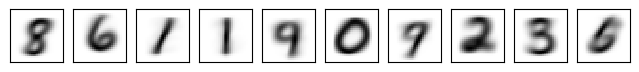

In [41]:
# Visualizing the clusters to see the numbers
fig, ax = plt.subplots(1, 10, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 28, 28)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [43]:

#Display multiple digits
def showDigits(digits, labels, indexes, size=28):
    #Make a grid that is the right size
    pics = len(indexes)
    cols = 6
    rows = math.ceil(pics/cols)
    fig, axes = plt.subplots(rows, cols, figsize=(14,6))
    plt.axis("off")

    #loop through the list of indexes, grab images and labels, plot in the "next" spot. 
    for i in range(0, pics):
        n = indexes[i]
        some_digit = digits[n:n+1]
        some_digit_image = np.array(some_digit).reshape(size, size)
        ax = axes[i//cols, i%cols]
        ax.axis("off")
        ax.imshow(some_digit_image, cmap=mpl.cm.binary)
        ax.set_title('Ind: {} - Lbl: {}'.format(indexes[i], labels[n]))
    plt.tight_layout()
    plt.axis("off")
    plt.show()

In [36]:
manual_labels = {0: 8, 1: 6, 2: 1, 3: 1, 4: 9, 5: 0, 6: 7, 7: 2, 8: 3, 9: 5}

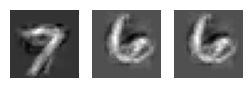

In [38]:
# Train GMM for each cluster
gmm_models = {}
for cluster_label in manual_labels.values():
    cluster_data = X[clusters == cluster_label]
    gmm = GaussianMixture(n_components=5, random_state=42)  # You can adjust the number of components
    gmm.fit(cluster_data)
    gmm_models[cluster_label] = gmm

# Write a function for digit generation
def writeNumber(number):
    fig, axs = plt.subplots(1, len(str(number)), figsize=(len(str(number)), 1))

    for i, digit in enumerate(str(number)):
        digit = int(digit)
        gmm_model = gmm_models[manual_labels[digit]]
        generated_digit = gmm_model.sample()
        generated_digit = generated_digit[0].reshape(28, 28)  # Assuming MNIST image size
        axs[i].imshow(generated_digit, cmap='gray')
        axs[i].axis('off')

    plt.show()

# Example: Generate and display the number 123
writeNumber(123)

c:\Users\desla\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


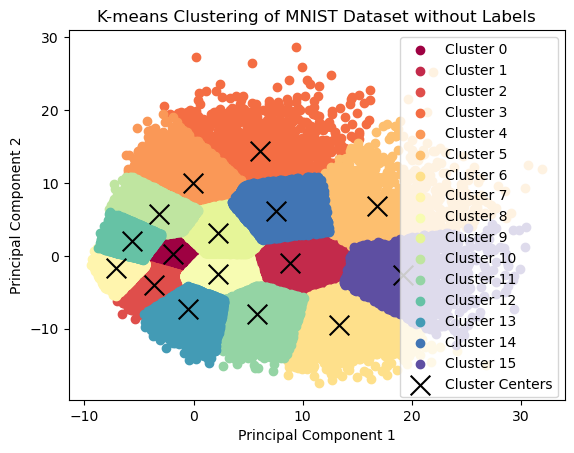

In [20]:
# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Reduce dimensionality using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Apply K-means clustering
n_clusters = 16  # Number of clusters (you can adjust this)
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_pca)

# Visualize the clusters
colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))
for i in range(n_clusters):
    cluster_points = X_pca[kmeans.labels_ == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=[colors[i]], label=f'Cluster {i}')

# Plot the cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], marker='x', s=200, c='black', label='Cluster Centers')

plt.title('K-means Clustering of MNIST Dataset without Labels')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

c:\Users\desla\anaconda3\Lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(
c:\Users\desla\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


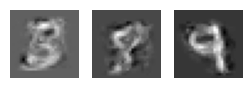

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load MNIST dataset
mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target.astype(int)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensionality using PCA (optional)
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(X_pca)

# Manually assign labels to clusters
# (You need to inspect the clusters and assign labels based on your observations)
manual_labels = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}

# Train GMM for each cluster
gmm_models = {}
for cluster_label in manual_labels.values():
    cluster_data = X[clusters == cluster_label]
    gmm = GaussianMixture(n_components=5, random_state=42)  # You can adjust the number of components
    gmm.fit(cluster_data)
    gmm_models[cluster_label] = gmm

# Write a function for digit generation
def writeNumber(number):
    fig, axs = plt.subplots(1, len(str(number)), figsize=(len(str(number)), 1))

    for i, digit in enumerate(str(number)):
        digit = int(digit)
        gmm_model = gmm_models[manual_labels[digit]]
        generated_digit = gmm_model.sample()
        generated_digit = generated_digit[0].reshape(28, 28)  # Assuming MNIST image size
        axs[i].imshow(generated_digit, cmap='gray')
        axs[i].axis('off')

    plt.show()

# Example: Generate and display the number 123
writeNumber(123)